In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
from config import settings
from retrieve_data import SQLiteRepo
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
repo = SQLiteRepo(connection=connection)  # REMOVERHS

print("repo type:", type(repo))
print("repo.connection type:", type(repo.connection))

repo type: <class 'retrieve_data.SQLiteRepo'>
repo.connection type: <class 'sqlite3.Connection'>


In [7]:
df_eurusd = repo.read_table(table_name="EURUSD", limit=3_000)  # REMOVERHS

print("df_eurusd type:", type(df_eurusd))
print("df_eurusd shape:", df_eurusd.shape)
df_eurusd.head()

df_eurusd type: <class 'pandas.core.frame.DataFrame'>
df_eurusd shape: (3000, 5)


,open,high,low,close,tick_volume
date,,,,,
2013-06-05,1.30796,1.31157,1.30530,1.30921,164426
2013-06-06,1.30917,1.33059,1.30744,1.32446,169056
2013-06-07,1.32442,1.32844,1.31912,1.32180,125515
2013-06-08,1.32180,1.32304,1.32118,1.32168,1450
2013-06-10,1.31894,1.32687,1.31769,1.32559,95500


In [23]:
def calc_returns(ticker, n_observations=4_000):
    return ((repo.
            read_table(table_name=ticker, limit=n_observations+1)
            .assign(returns = lambda x: 100*x["close"].pct_change())
            .dropna())["returns"]
      )

df_ticker = calc_returns("EURUSD", n_observations=2500)

# Is `df_ticker` a Series?
assert isinstance(df_ticker, pd.Series)

# Are there 2500 observations in the `df_ticker` Series?
assert len(df_ticker) == 2500

# Is `df_ticker` name "returns"?
assert df_ticker.name == "returns"

# Does `df_ticker` have a DatetimeIndex?
assert isinstance(df_ticker.index, pd.DatetimeIndex)

# Is the index of `df_ticker` sorted ascending?
assert all(df_ticker.index == df_eurusd.sort_index(ascending=True).index)

# Are there no `NaN` values?
assert df_ticker.isnull().sum() == 0

df_ticker.head()

date
2015-01-16   -0.428656
2015-01-17   -0.025069
2015-01-18   -0.034587
2015-01-19    0.409999
2015-01-20   -0.501361
Name: returns, dtype: float64

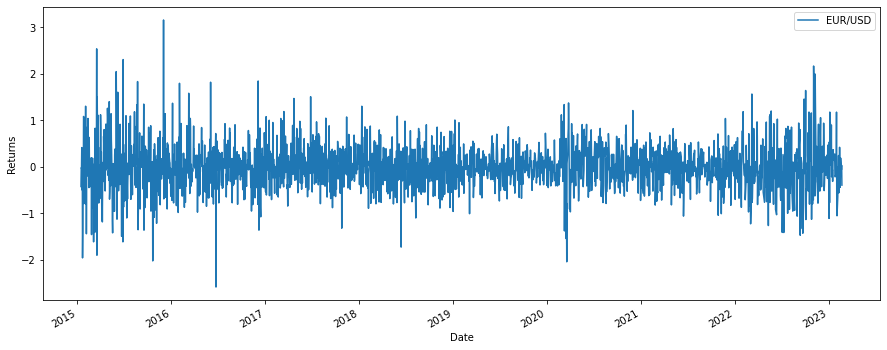

In [26]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for `EURUSD`
df_ticker.plot(ax=ax, label="EUR/USD")


# Label axes
plt.xlabel("Date")
plt.ylabel("Returns")

# Add legend
_=plt.legend()

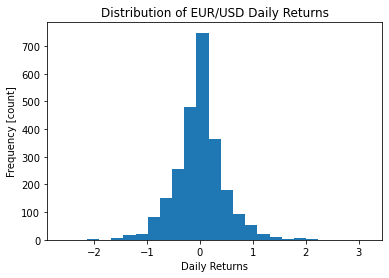

In [27]:
# Create histogram of `y_ambuja`, 25 bins
plt.hist(df_eurusd, bins=25)  # REMOVELINE

# Add axis labels
plt.xlabel("Daily Returns")  # REMOVELINE
plt.ylabel("Frequency [count]")  # REMOVELINE

# Add title
plt.title("Distribution of EUR/USD Daily Returns");

In [29]:
eurusd_daily_volatility = df_eurusd.std() 

print(f"EUR-USD Daily Volatility: {eurusd_daily_volatility:.4f}")

EUR-USD Daily Volatility: 0.4709


In [30]:
eurusd_annual_volatility = eurusd_daily_volatility * np.sqrt(252)  # REMOVERHS

print(f"Suzlon Annual Volatility: {eurusd_annual_volatility:.4f}")

Suzlon Annual Volatility: 7.4750


In [31]:
eurusd_rolling_50d_volatility = (df_eurusd
                                 .rolling(window=50)
                                 .std()
                                 .dropna())

print(f"rolling_50d_volatility type: {type(eurusd_rolling_50d_volatility)}")
print(f"rolling_50d_volatility shape: {eurusd_rolling_50d_volatility.shape}")
eurusd_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (2451,)


date
2015-03-06    0.671721
2015-03-07    0.670461
2015-03-08    0.670592
2015-03-09    0.670974
2015-03-10    0.690709
Name: returns, dtype: float64

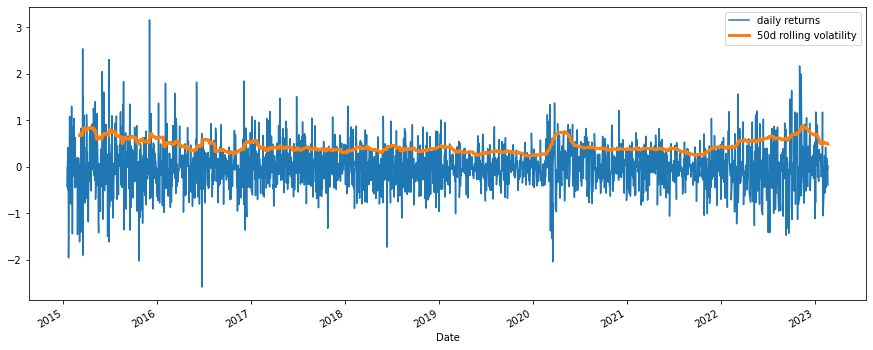

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `df_eurusd`
df_eurusd.plot(ax=ax, label="daily returns")  

# Plot `eurusd_rolling_50d_volatility`
eurusd_rolling_50d_volatility.plot(ax=ax, label="50d rolling volatility", linewidth=3)


# Add x-axis label
plt.xlabel("Date")  

# Add legend
_=plt.legend()

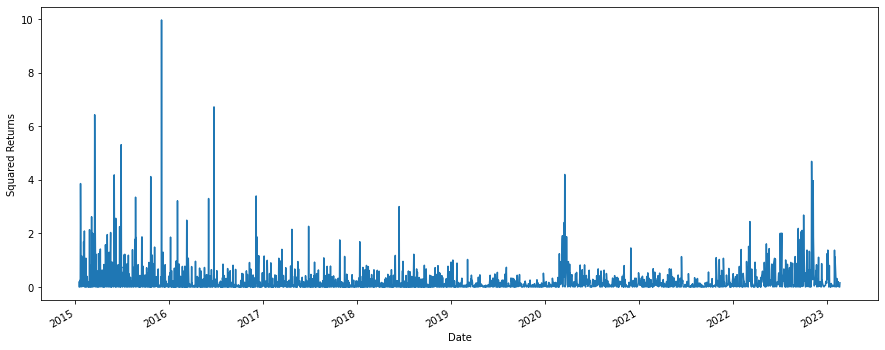

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(df_eurusd**2).plot(ax=ax)  

# Add axis labels
plt.xlabel("Date")  
_=plt.ylabel("Squared Returns")

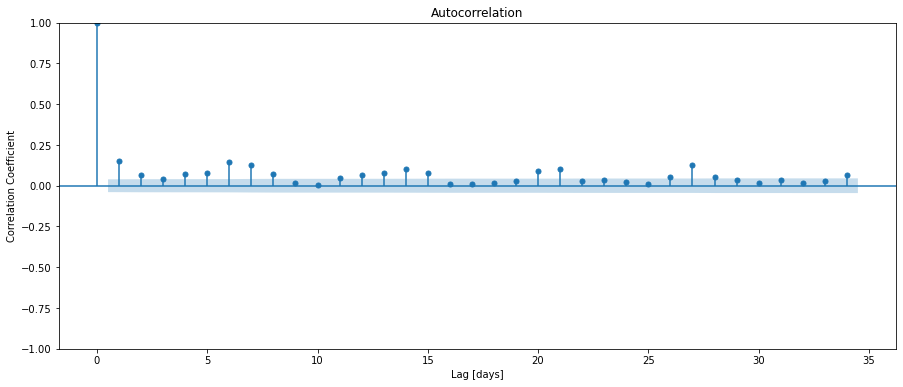

In [34]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(df_eurusd**2, ax=ax)  # REMOVELINE

# Add axis labels
plt.xlabel("Lag [days]")  
_=plt.ylabel("Correlation Coefficient")

C:\Users\ricky\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


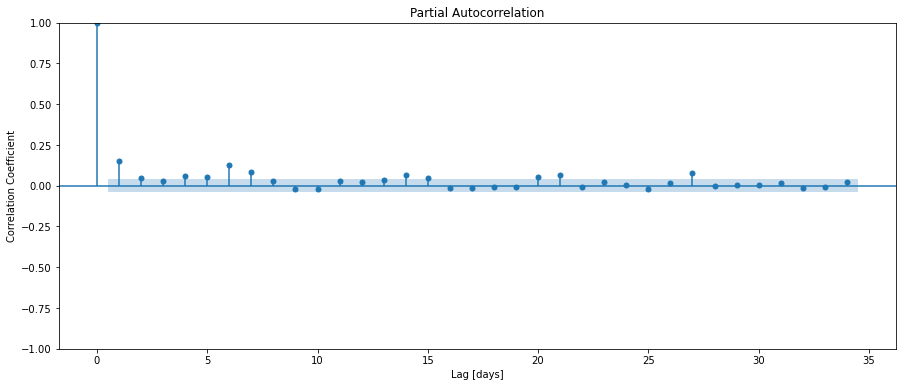

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_pacf(df_eurusd**2, ax=ax)  # REMOVELINE

# Add axis labels
plt.xlabel("Lag [days]")  
_=plt.ylabel("Correlation Coefficient")

In [37]:
cutoff_test = int(len(df_eurusd) * 0.8)  # REMOVERHS
df_eurusd_train = df_eurusd.iloc[:cutoff_test]  # REMOVERHS

print(f"df_eurusd data type: {type(df_eurusd)}")
print(f"df_eurusd_train shape: {df_eurusd.shape}")
df_eurusd_train.tail()

df_eurusd data type: <class 'pandas.core.series.Series'>
df_eurusd_train shape: (2500,)


date
2021-03-17    0.652831
2021-03-18   -0.525890
2021-03-19   -0.108251
2021-03-22    0.251180
2021-03-23   -0.720648
Name: returns, dtype: float64

In [38]:
# Build and train model
model = arch_model(df_eurusd_train, p=1, q=1, rescale=False).fit(disp=0)  # REMOVERHS
print(f"model type: {type(model)}")

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1175.06
Distribution:                  Normal   AIC:                           2358.13
Method:            Maximum Likelihood   BIC:                           2380.53
                                        No. Observations:                 2000
Date:                Wed, Feb 22 2023   Df Residuals:                     1999
Time:                        19:49:46   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.8368e-03  9.367e-03      0.410      0.682 [-1.452e-02,2.220e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      8.9826e-04  8.383e-04      1.072      0.284 [-7.447e-04,2.541e-03]
alpha[1]       0.0147  1.207e-02      1.217      0.224 [-8.963e-03,3.833e-02]
beta[1]        0.9800  1.552e-02     63.131      0.000      [  0.950,  1.010]
=============================================================================

Covariance estimator: robust
"""

In [42]:
print(f"Model AIC: {model.aic:.4f}")
print(f"Model BIC: {model.bic:.4f}")

Model AIC: 2358.1257
Model BIC: 2380.5293


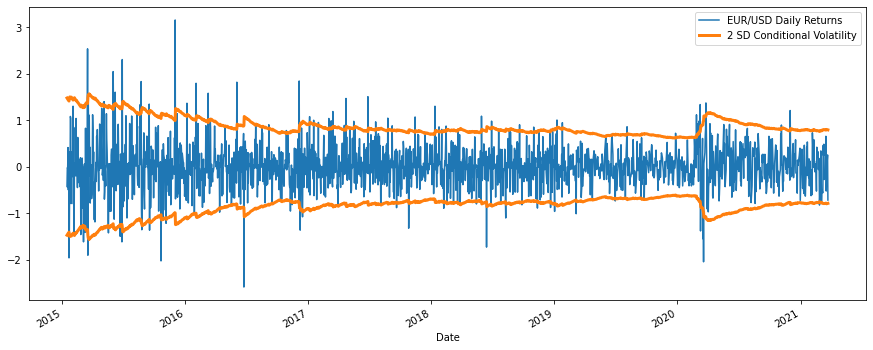

In [43]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `df_eurusd_train`
df_eurusd_train.plot(ax=ax, label="EUR/USD Daily Returns")  

# Plot conditional volatility * 2
(2 * model.conditional_volatility).plot(
    ax=ax, color="C1", label="2 SD Conditional Volatility", linewidth=3
)


# Plot conditional volatility * -2
(-2 * model.conditional_volatility.rename("")).plot(ax=ax, color="C1", linewidth=3)

# Add axis labels
plt.xlabel("Date")  


# Add legend
_=plt.legend()

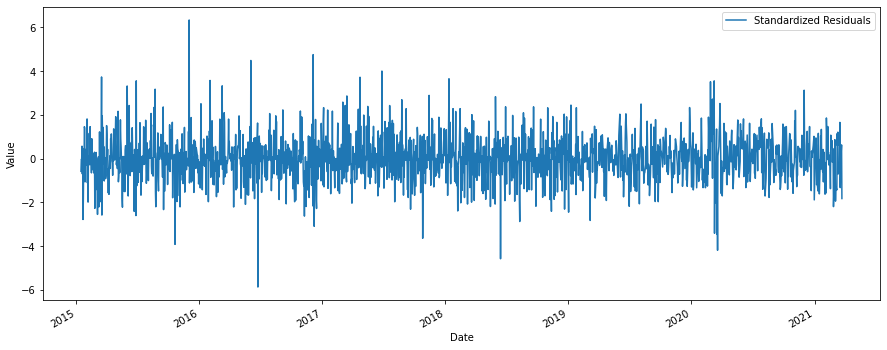

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")  

# Add axis labels
plt.xlabel("Date")  
plt.ylabel("Value")  

# Add legend
_=plt.legend()

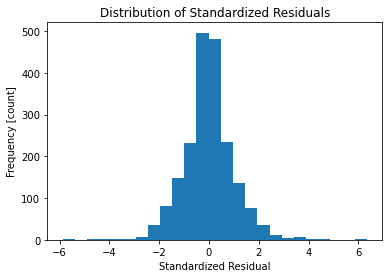

In [45]:
# Create histogram of standardized residuals, 25 bins
plt.hist(model.std_resid, bins=25) 

# Add axis labels
plt.xlabel("Standardized Residual")  
plt.ylabel("Frequency [count]")  

# Add title
_=plt.title("Distribution of Standardized Residuals")

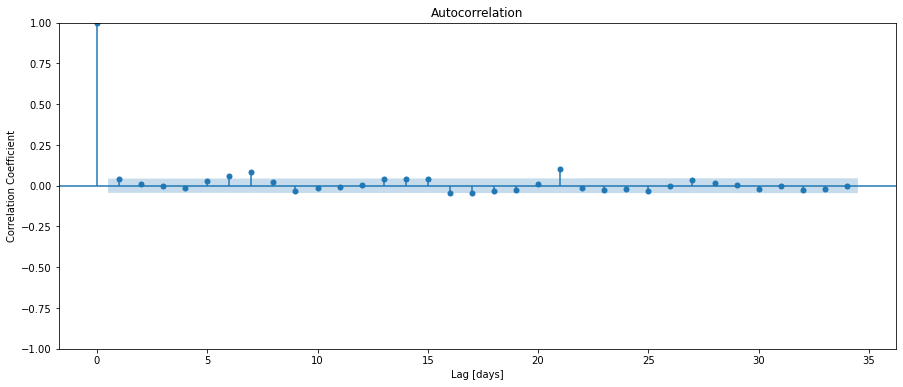

In [46]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)  

# Add axis labels
plt.xlabel("Lag [days]")  
_=plt.ylabel("Correlation Coefficient")

In [48]:
one_day_forecast = model.forecast(horizon=1, reindex=False).variance  

print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
date,
2021-03-23,0.162013


In [49]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(df_eurusd) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = df_eurusd.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train, p=1, q=1, rescale=False).fit(disp=0)  

    # Generate next prediction (volatility, not variance)    
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0, 0] ** 0.5
    

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=df_eurusd.tail(test_size).index)

print(f"y_test_wfv type: {type(y_test_wfv)}")
print(f"y_test_wfv shape: {y_test_wfv.shape}")
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (500,)


date
2021-03-24    0.402509
2021-03-25    0.401417
2021-03-26    0.401174
2021-03-29    0.399156
2021-03-30    0.397327
dtype: float64

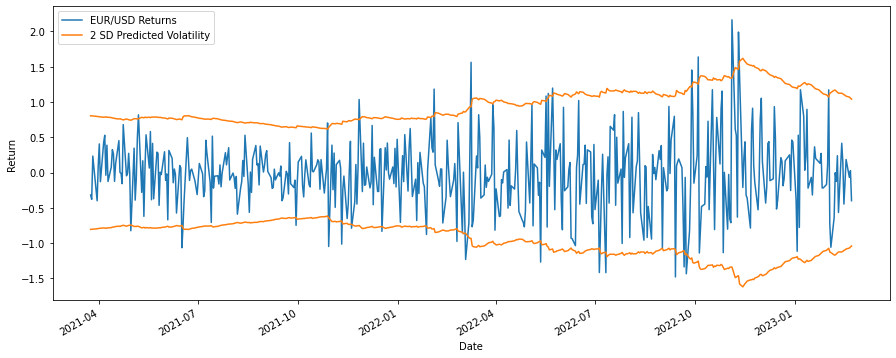

In [50]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
df_eurusd.tail(test_size).plot(ax=ax, label="EUR/USD Returns")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
_=plt.legend()

In [51]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5


# Calculate forecast start date
start = prediction.index[0] + pd.DateOffset(days=1)  

# Create date range
prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])  

# Create prediction index labels, ISO 8601 format
prediction_index = [d.isoformat() for d in prediction_dates]  

print(f"prediction_index type: {type(prediction_index)}")
print(f"prediction_index len: {len(prediction_index)}")
prediction_index[:3]

prediction_index type: <class 'list'>
prediction_index len: 5


['2023-02-22T00:00:00', '2023-02-23T00:00:00', '2023-02-24T00:00:00']

In [52]:
# INSERT def clean_prediction():
def clean_prediction(prediction):  
    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0] + pd.DateOffset(days=1)  

    # Create date range
    prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])
    

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]  

    # Extract predictions from DataFrame, get square root
    data = prediction.values.flatten() ** 0.5  

    # Combine `data` and `prediction_index` into Series
    prediction_formatted = pd.Series(data, index=prediction_index)  

    # Return Series as dictionary
    return (pd.Series(data, index=prediction_index)
            .to_dict())

In [53]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted

{'2023-02-22T00:00:00': 0.5203102763043348,
 '2023-02-23T00:00:00': 0.519936925891252,
 '2023-02-24T00:00:00': 0.5195654355918036,
 '2023-02-27T00:00:00': 0.5191957972696488,
 '2023-02-28T00:00:00': 0.51882800281449,
 '2023-03-01T00:00:00': 0.5184620441420609,
 '2023-03-02T00:00:00': 0.5180979131941135,
 '2023-03-03T00:00:00': 0.5177356019384062,
 '2023-03-06T00:00:00': 0.5173751023686898,
 '2023-03-07T00:00:00': 0.5170164065046935}